# Pneumonia Detection from CXR

* **Project Overview**:

    * In this project, we utilized the Kaggle RSNA Pneumonia Detection Challenge dataset to train a neural network model for pneumonia detection. The dataset includes chest X-ray (CXR) images in DICOM format and corresponding pneumonia labels.
    * The model was trained to accurately distinguish between pneumonia and non-pneumonia cases, with the aim of assisting in the automated detection of pneumonia from medical imaging.
    * The DICOM metadata is reviewed to extract any non-image features that may influence the interpretation of chest X-ray images. This process helps determine whether additional features—such as patient background or imaging settings—could enhance the model's predictive performance.

* Kaggle Link: [Competition Link: https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/](https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/)
    * The training dataset consists a total of 26,684 chest radiographs in DICOM format.

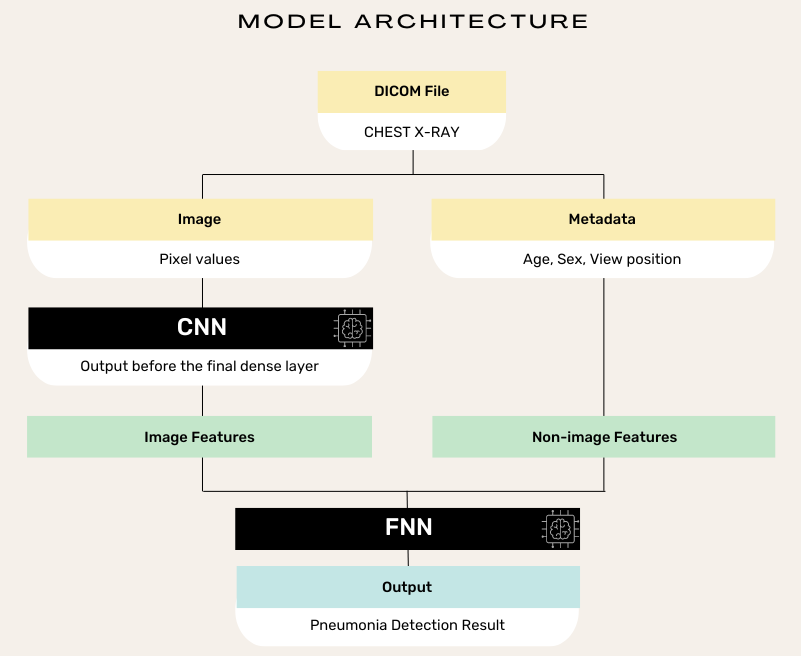

## Setup and Import Libraries



In [ ]:
!pip install pydicom
!pip install tensorflow-io
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
import pydicom
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_io as tfio
import keras
from tensorflow.keras import metrics
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt

from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
# Suppress the specific FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

load_dicom_data = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_directory = '/content/drive/MyDrive/Side Project/rsna-pneumonia-detection-challenge/'

In [ ]:
os.chdir(root_directory)

In [ ]:
# Helper function to display CXR with given patientId
# def show_cxr(patientId, title='CXR'):
#     dcm = pydicom.dcmread(f'stage_2_train_images/{patientId}.dcm')
#     image = dcm.pixel_array
#     # Display the image
#     plt.figure(figsize=(3, 3))
#     plt.imshow(image, cmap='gray')
#     plt.axis('off')  # Turn off axis labels
#     plt.title(title)
#     plt.show()

In [ ]:
def set_random_seed():
  seed = 18
  # Set random seeds for reproducibility
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

  # (For TensorFlow GPU determinism)
  os.environ['CUDA_VISBLE_DEVICE'] = ''
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['PYTHONHASHSEED'] = str(1234)

## Part 1: Data Loading

### 1.1: Data Labels

**Preview of Raw Data Labels**

There are two separate files that contain the labels for chest x-ray images.

* stage_2_detailed_class_info.csv
* stage_2_train_labels.csv

In [ ]:
raw_label = pd.read_csv("stage_2_detailed_class_info.csv")
train_label = pd.read_csv("stage_2_train_labels.csv")

### 1.2: Load Non-image Data from DICOM

Get a preview of metadata in DICOM file

In [ ]:
dcm = pydicom.dcmread('stage_2_train_images/e122edcb-dab7-4a4c-8fd3-ab0ee84ce6b9.dcm')
print("Successfully read in sample cxr dcm")
print(dcm)
# dcm.PatientID = "0123456789"
# image = dcm.pixel_array

Successfully read in sample cxr dcm
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 200
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.16703.1517874399.40396
(0002,0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.16703.1517874399.40396
(0008,0020) Study Date                          DA: '19010101'
(0008,

The objective in this section is to extract relevant information from the DICOM file, including:

* Patient ID,
* UID (unique identifier for each DICOM image),
* Sex,
* Age (calculated as the difference between the study date and birthday),
* View position (PA or AP),
* Body Part Examined,
* Image Size (row and column).

The chest x-ray pixels are too large to fit into memory, so we need to create a generator that loads data on the fly before model training.

In [ ]:
def get_dicom_data(directory):

  data = []

  # Iterate over all DICOM files in the given directory
  for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)

    if os.path.isfile(file_path):  # Check if it's a file
      try:
          # Attempt to read the file as a DICOM file
          ds = pydicom.dcmread(file_path, stop_before_pixels=True)

          # Extract required information
          patient_id = ds.PatientID
          uid = ds.StudyInstanceUID
          sex = ds.PatientSex
          age = ds.PatientAge
          view_position = ds.ViewPosition if 'BodyPartExamined' in ds else None
          body_part_examined = ds.BodyPartExamined if 'BodyPartExamined' in ds else None
          row = ds.Rows
          col = ds.Columns


          # Add the information to the list
          data.append({
              'patientId': patient_id,
              'uid': uid,  # Used to distinguish different CXR of the same patient
              'sex': sex,
              'age': age,
              'view_position': view_position,
              'body_part_examed': body_part_examined,
              'row': row,
              'col': col
          })

      except (pydicom.errors.InvalidDicomError, ValueError):
          print(f'{filename} is not a DICOM file.')

  # Create a DataFrame from the data list
  data_df = pd.DataFrame(data)
  return data_df

In [ ]:
# Execute this cell only if we want to read from DICOM data again
if load_dicom_data:
    train_data = get_dicom_data('stage_2_train_images')
    # Stored the retrieved data (Saving time to import from DICOM next time)
    train_data.to_csv('train_data.csv')

## Part 2: Data Processing

Now, we have three tables:

* `raw_label`: Contains detailed CXR classifications ('No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity').

* `train_label`: Includes the classification of whether pneumonia is present (Target = 0 or 1).

* `train_data`: Contains CXR metadata extracted from DICOM files (sex, age, view_position, body_part_examed, row, col).

### Labels

Check data type

In [ ]:
raw_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
train_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
raw_label['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

In [ ]:
train_label['Target'].unique()

array([0, 1])

We need to clarify how the three raw data classes map to the binary target labels.

1. **Raw Data Labels:**

  * The chest X-ray images are classified into three categories:

    `'No Lung Opacity / Not Normal'`

    `'Normal'`

    `'Lung Opacity'`
2. **Training Labels:**

  * The training dataset only contains binary labels:

    `Target = 0`

    `Target = 1`



In [ ]:
combined_label = pd.merge(raw_label, train_label[['patientId', 'Target']], on='patientId', how='outer')
grouped_table = combined_label.groupby(['Target', 'class']).count()

In [ ]:
grouped_table.head()

patientId
Target class                                  
0      No Lung Opacity / Not Normal      11821
       Normal                             8851
1      Lung Opacity                      16957

> Since both "No Lung Opacity / Not Normal" and "Normal" are labeled as Target = 0, if we train the model using Target = 1 and Target = 0, the model will be designed to distinguish between chest X-rays with and without pneumonia. However, it won't be able to determine whether a chest X-ray is normal or not.*



Check for duplicated patientId

In [ ]:
duplicated_patient_ids = train_label[train_label.duplicated(subset='patientId', keep=False)]
print(f"There are {len(duplicated_patient_ids['patientId'].unique())} patients having more than 1 labels.")
print(f"The values of the labels are {duplicated_patient_ids['Target'].unique()}")

There are 3398 patients having more than 1 labels.
The values of the labels are [1]


Since all duplicated labels are identical, it is not possible for a patient to have two different labels for their CXR images. Therefore, we can retain only one instance of the duplicated data.



In [ ]:
# Remove duplicates
train_label = train_label.drop_duplicates(subset='patientId', keep='first')

### DICOM data

In [ ]:
train_data = pd.read_csv('train_data.csv', index_col=0)

Check Data Type

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26684 entries, 0 to 26885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   patientId         26684 non-null  object
 1   uid               26684 non-null  object
 2   sex               26684 non-null  object
 3   age               26684 non-null  int64 
 4   view_position     26684 non-null  object
 5   body_part_examed  26684 non-null  object
 6   row               26684 non-null  int64 
 7   col               26684 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 1.8+ MB


Convert categorical variable to integer: `'sex'` and `'view_position'`.

In [ ]:
print(f"The unique values for sex is {train_data['sex'].unique()}")
print(f"The unique values for veiw_position is {train_data['view_position'].unique()}")

The unique values for sex is ['F' 'M']
The unique values for veiw_position is ['AP' 'PA']


* Encode sex = 1 for 'M', sex = 0 for 'F'.
* Encode view_position = 1 for 'PA', view_position = 0 for 'AP'.

In [ ]:
train_data['sex'] = train_data['sex'].apply(lambda sex: 1 if sex == 'M' else 0)
train_data['view_position'] = train_data['view_position'].apply(lambda vp: 1 if vp == 'PA' else 0)

Check duplicated chest x-ray images by `'uid'`.

In [ ]:
duplicated_dicom = train_data[train_data.duplicated(subset='uid', keep=False)]
print(f"There are {len(duplicated_dicom['uid'].unique())} DICOM images with duplication(s).")

There are 0 DICOM images with duplication(s).


Remove duplicated DICOM images.

In [ ]:
train_data = train_data.drop_duplicates(subset='uid', keep='first')
duplicated_patient_ids = train_data[train_data.duplicated(subset='patientId', keep=False)]
print(f"After removed duplicated DICOM images, there is {len(duplicated_patient_ids)} duplicated patient id.")

After removed duplicated DICOM images, there is 0 duplicated patient id.


In [ ]:
merged_table = pd.merge(train_data, train_label[['patientId', 'Target']], on='patientId', how='outer')
merged_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   patientId         26684 non-null  object
 1   uid               26684 non-null  object
 2   sex               26684 non-null  int64 
 3   age               26684 non-null  int64 
 4   view_position     26684 non-null  int64 
 5   body_part_examed  26684 non-null  object
 6   row               26684 non-null  int64 
 7   col               26684 non-null  int64 
 8   Target            26684 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.8+ MB


All DICOM images have corresponding labels, and there are no missing values.

**Confirmation of Chest X-ray Examination Body Part**

Make sure that all X-ray images are of the chest area, and there are no images from other anatomical locations mixed in.

In [ ]:
merged_table['body_part_examed'].unique()

array(['CHEST'], dtype=object)

**Check DICOM image size**

Verify that all DICOM images have the same pixel size.

In [ ]:
print(f"All unique row number(s) of DICOM images: {merged_table['row'].unique()}")
print(f"All unique column number(s) of DICOM images: {merged_table['col'].unique()}")

All unique row number(s) of DICOM images: [1024]
All unique column number(s) of DICOM images: [1024]


**Remove Invalid age**

The longest documented and verified human lifespan is 122 years and 164 days. Consequently, we will consider any age greater than 123 as invalid data.

In [ ]:
merged_table[merged_table['age'] > 123]

,patientId,uid,sex,age,view_position,body_part_examed,row,col,Target
4115,3b8b8777-a1f6-4384-872a-28b95f59bf0d,1.2.276.0.7230010.3.1.2.8323329.14774.15178743...,1,148,1,CHEST,1024,1024,0
10648,73aeea88-fc48-4030-8564-0a9d7fdecac4,1.2.276.0.7230010.3.1.2.8323329.21167.15178744...,0,151,1,CHEST,1024,1024,0
16213,a4e8e96d-93a6-4251-b617-91382e610fab,1.2.276.0.7230010.3.1.2.8323329.15621.15178743...,1,153,1,CHEST,1024,1024,0
24374,ec3697bd-184e-44ba-9688-ff8d5fbf9bbc,1.2.276.0.7230010.3.1.2.8323329.7426.151787433...,1,150,1,CHEST,1024,1024,0
25537,f632328d-5819-4b29-b54f-adf4934bbee6,1.2.276.0.7230010.3.1.2.8323329.4886.151787431...,0,155,1,CHEST,1024,1024,0


We have 5 invalid age. Remove these data.

In [ ]:
merged_table = merged_table[merged_table['age'] <= 123]

**Remove pediatric CXR**



> It is well known that the interpretation of pediatric chest radiographs differs from that in adult chest radiographs. There is a varying radiographic appearance of the normal growing child, ranging from tiny premature neonates to adolescents. Pediatric radiography often utilizes differing techniques of acquisition, and frequently, differing pathologies are encountered that are not commonly seen in adults. (Ref: [Pediatr Radiol. 2022; 52(8): 1568–1580.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9033522/))

For example, the adult and pediatric CXR from our training set:



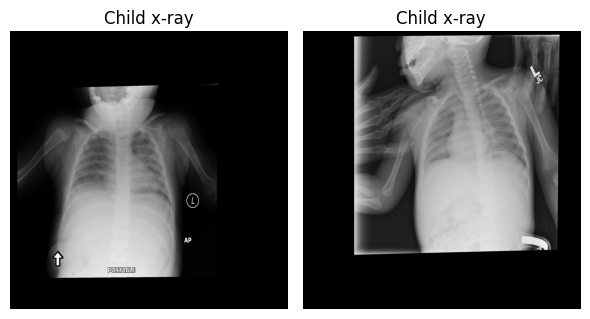

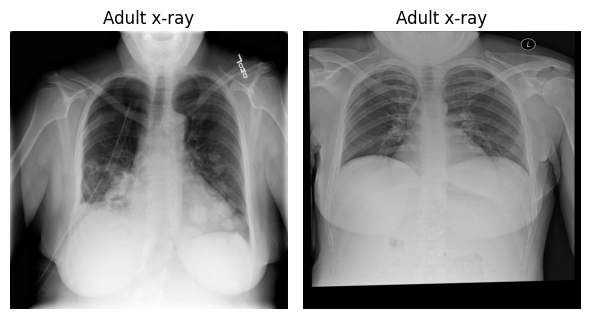

In [ ]:
child_id = merged_table.loc[merged_table['age'] < 2]['patientId']
i = 0
plt.figure(figsize=(6,12))
for id in child_id:
    plt.subplot(2,2, i+1)
    dcm = pydicom.dcmread(f'stage_2_train_images/{id}.dcm')
    image = dcm.pixel_array
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.title("Child x-ray")
    i += 1
plt.tight_layout()

adult_id = merged_table.loc[merged_table['age'] >= 18 ]['patientId']
i = 0
plt.figure(figsize=(6,12))
for id in adult_id:
    if i < 2:
        plt.subplot(2,2, i+1)
        dcm = pydicom.dcmread(f'stage_2_train_images/{id}.dcm')
        image = dcm.pixel_array
        plt.imshow(image, cmap='gray')
        plt.axis('off')  # Turn off axis labels
        plt.title("Adult x-ray")
        i += 1
plt.tight_layout()

Remove pediatric chest x-ray from our data.

In [ ]:
merged_table = merged_table[merged_table['age'] >= 18]

## Part 3: Exploratory Data Analysis

### Class Imbalance

Significant class imbalance is shown in the plot below.

The number of CXR without pneumonia is significantly more than those with pneumonia. We need to address class imbalance issue while training the model.

In [ ]:
merged_table.groupby('Target').size().reset_index(name='count')

,Target,count
0,0,19776
1,1,5627


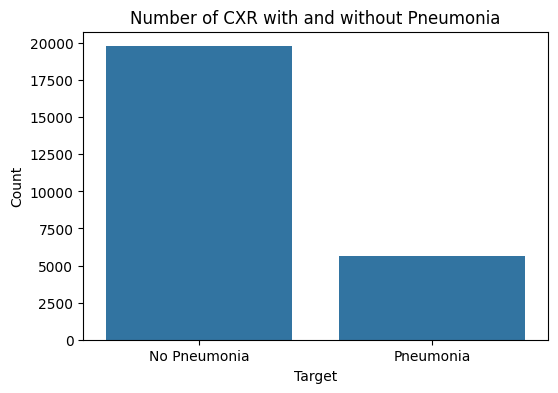

In [ ]:
# Set the figure size
plt.figure(figsize=(6, 4))
sns.countplot(data=merged_table, x='Target')
# Set the title and labels
plt.title('Number of CXR with and without Pneumonia')
plt.xlabel('Target')
plt.ylabel('Count')
# Customize x-ticks
plt.xticks(ticks=[0, 1], labels=['No Pneumonia', 'Pneumonia'])
plt.show()

### Age Distribution

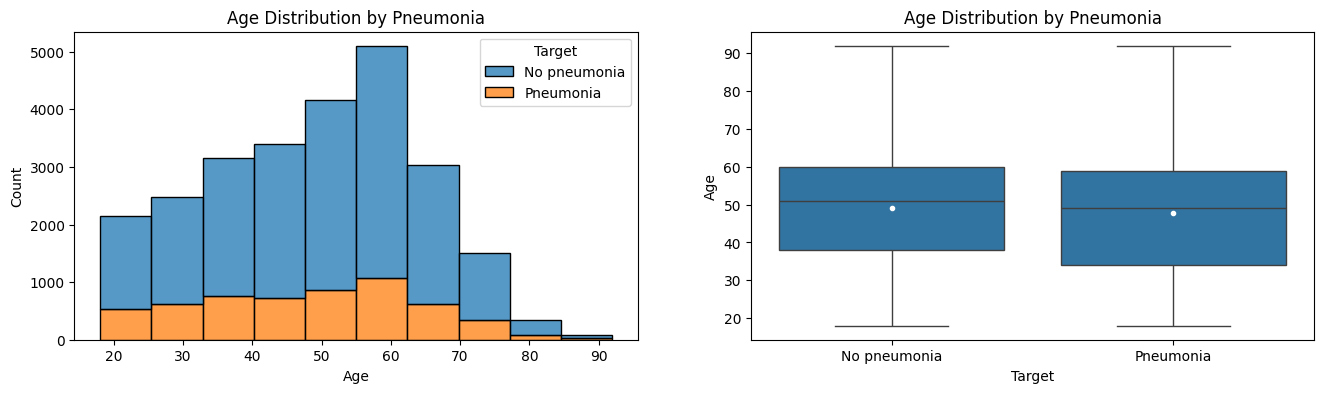

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
# Create a histogram of age distribution with different target values
sns.histplot(data=merged_table, x='age', hue=merged_table['Target'].apply(lambda x: 'Pneumonia' if x == 1 else 'No pneumonia'), multiple='stack', bins=10)
# Set the title and labels
plt.title('Age Distribution by Pneumonia')
plt.xlabel('Age')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
# Create the boxplot
sns.boxplot(data=merged_table,
            x=merged_table['Target'].apply(lambda x: 'Pneumonia' if x == 1 else 'No pneumonia'),
            y='age',
            showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"white", "markersize":"3"})
# Set the title and labels
plt.title('Age Distribution by Pneumonia')
plt.xlabel('Target')
plt.ylabel('Age')


# Display the plot
plt.show()

The age distribution in the pneumonia and non-pneumonia groups, as observed in the histogram, is not normally distributed. Therefore, we apply a non-parametric test to compare the means using the Mann-Whitney U Test.

In [ ]:
# Assuming 'group1' and 'group2' are your two independent samples
group1 = merged_table[merged_table['Target'] == 1]['age']  # Pneumonia group
group2 = merged_table[merged_table['Target'] == 0]['age']  # No pneumonia group

# Perform Mann-Whitney U Test
stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')

print(f"Mann-Whitney U Test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

Mann-Whitney U Test statistic: 53232604.5
P-value: 7.032487385224385e-07
There is a significant difference between the two groups.


In [ ]:
fit1 = smf.glm('Target~age',
               data = merged_table,
               family=sm.families.Binomial()).fit()
print(fit1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Target   No. Observations:                25403
Model:                            GLM   Df Residuals:                    25401
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13421.
Date:                Wed, 16 Oct 2024   Deviance:                       26842.
Time:                        16:55:00   Pearson chi2:                 2.54e+04
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0009615
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0182      0.050    -20.247      0.0

From the Logistic regression results above, we can see that the coefficients on age variable is statistically significant with p-value < 0.05. Hence, we can reject the null hypothesis that there is no difference in age among different chest x-ray group.

**The percentage of pneumonia within different age groups**

<Figure size 400x300 with 0 Axes>

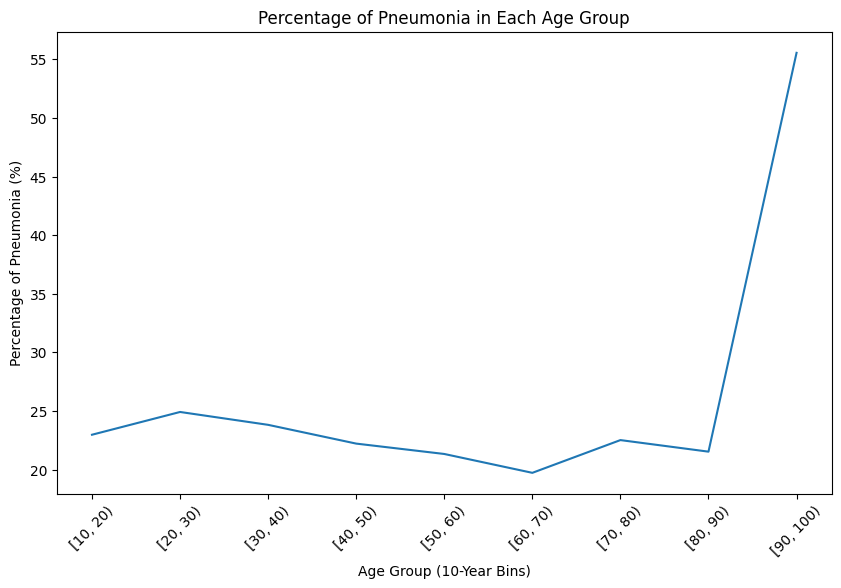

In [ ]:
plt.figure(figsize=(4, 3))

# Create 10-year age bins
merged_table['age_group'] = pd.cut(merged_table['age'], bins=range(10, 101, 10), right=False)

# Calculate the percentage of pneumonia in each age group
percentage_df = merged_table.groupby('age_group')['Target'].mean() * 100  # Calculate mean of `Target=1` and multiply by 100 to get percentage

# Plot the percentage of pneumonia in each age group
plt.figure(figsize=(10, 6))
sns.lineplot(x=percentage_df.index.astype(str), y=percentage_df.values)

# Set the labels and title
plt.xlabel('Age Group (10-Year Bins)')
plt.ylabel('Percentage of Pneumonia (%)')
plt.title('Percentage of Pneumonia in Each Age Group')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()

In [ ]:
print(f"The number of chest x-rays with age in range 90-100: {len(merged_table[merged_table['age'] > 90])}")

The number of chest x-rays with age in range 90-100: 4


Although the proportion of pneumonia in the 90-100 age group appears unusually high, there are actually only 4 data points, so the sample size is too small to conclude that older patients have a higher rate of pneumonia on CXR.

### Sex

In [ ]:
print("The percentage of males in each target group:")
percentage_male = merged_table.groupby('Target')['sex'].mean() * 100
percentage_male = percentage_male.round(2).astype(str) + '%'
print(percentage_male)

The percentage of males in each target group:
Target
0    56.16%
1    58.24%
Name: sex, dtype: object


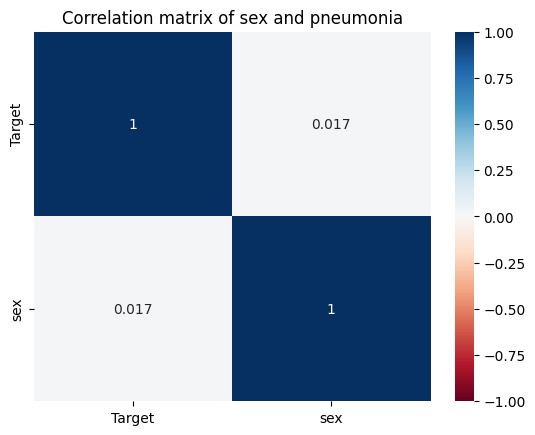

The correlation between sex and pneumonia is 0.02.


In [ ]:
# generate correlation matrix
sex_pneumonia_corr = merged_table[["Target", "sex"]].corr()
sex_pneumonia_heatmap = sns.heatmap(sex_pneumonia_corr, annot=True, cmap="RdBu", vmin=-1, vmax=1).set_title("Correlation matrix of sex and pneumonia")
plt.show(sex_pneumonia_heatmap)
print(f"The correlation between sex and pneumonia is {sex_pneumonia_corr['sex'].loc['Target']:.2f}.")

Given that the correlation coefficient is so low, sex might provide very little information about whether they have pneumonia or not.

### View Position

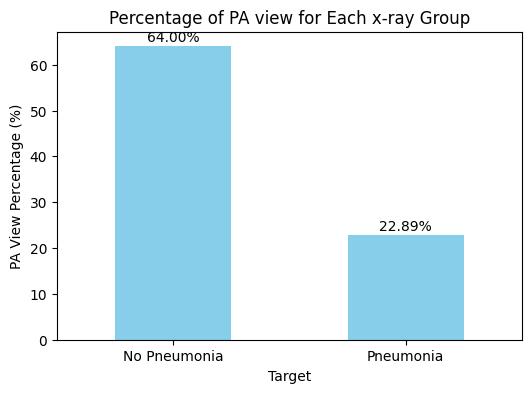

In [ ]:
percentage_PA = merged_table.groupby('Target')['view_position'].mean() * 100
plt.figure(figsize=(6, 4))
percentage_PA.plot(kind='bar', color='skyblue')

# Set title and labels
plt.title('Percentage of PA view for Each x-ray Group')
plt.xlabel('Target')
plt.ylabel('PA View Percentage (%)')

# Adding percentage labels on top of the bars
for i, v in enumerate(percentage_PA):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')

# Display the plot
plt.xticks(ticks=[0, 1], labels=["No Pneumonia", "Pneumonia"], rotation=0)
plt.show()


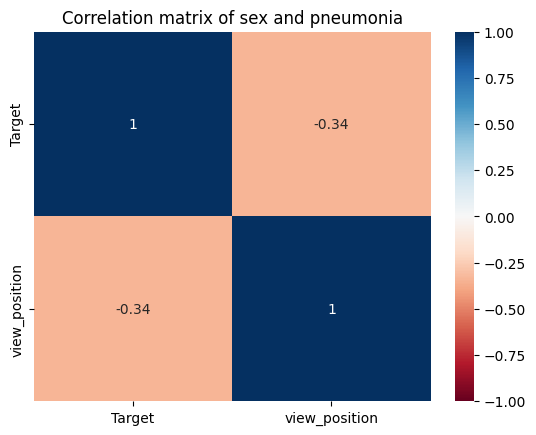

The correlation between view_position and pneumonia is -0.34.


In [ ]:
# generate correlation matrix
view_position_pneumonia_corr = merged_table[["Target", "view_position"]].corr()
view_position_pneumonia_heatmap = sns.heatmap(view_position_pneumonia_corr, annot=True, cmap="RdBu", vmin=-1, vmax=1).set_title("Correlation matrix of sex and pneumonia")
plt.show(view_position_pneumonia_heatmap)
print(f"The correlation between view_position and pneumonia is {view_position_pneumonia_corr['view_position'].loc['Target']:.2f}.")

There may be a moderate negative relationship between view_position and pneumonia. Therefore, we need to conduct a statistical analysis to determine if this relationship is statistically significant.

In [ ]:
# Create a contingency table
contingency_table = pd.crosstab(merged_table['Target'], merged_table['view_position'])

print("Contingency Table:")
print(contingency_table)

# Perform the Chi-Square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f'Chi-Square Statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degrees of Freedom: {dof}')
print(f'Expected Frequencies:\n{expected}')

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant association between pneumonia and view_position.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between pneumonia and view_position.")

Contingency Table:
view_position     0      1
Target                    
0              7120  12656
1              4339   1288
Chi-Square Statistic: 2987.8532923956277
P-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[ 8920.72526867 10855.27473133]
 [ 2538.27473133  3088.72526867]]
Reject the null hypothesis: There is a significant association between pneumonia and view_position.


The higher percentage of PA views observed in the no pneumonia group can be attributed to patient condition. Healthy individuals are generally able to stand and undergo PA chest X-rays. In contrast, AP views are commonly utilized for patients who are unable to stand, such as the elderly, bedridden individuals, or those who cannot stand due to illness. Pneumonia can make it difficult for patients to stand and receive a PA view; conversely, those who are unable to stand also represent a high-risk group for developing pneumonia. This may help explain why the proportion of PA views is lower in the pneumonia group.

## Part 4: Data Preparation

### Non-Image Features

**Age**

It is sometimes challenging to differentiate between age-related changes and pathological findings. For example, emphysematous changes and basal fibrotic changes are common in elderly patients. Since age can influence chest X-ray interpretation and exploratory data analysis (EDA) has shown a correlation between age and pneumonia, age will be included as a non-image feature to train the model for pneumonia detection.






**Sex and View Position**

Both variables influence how chest X-rays (CXR) are interpreted. Therefore, regardless of whether they show correlation with our target variable (pneumonia) in exploratory data analysis (EDA), they should still be included as variables in our model.

* Sex

    Although sex is not strongly correlated with the target label "pneumonia," CNN can still extract different features from chest X-ray pixels because male and female CXRs display distinct characteristics. For instance, female CXRs show distinct features such as:

    * **Prominent breast tissue**:
    
    Breast tissue absorbs some of the x-ray beam, which causes underexposure of tissues behind it. As a result, the lung behind the breast appears whiter, and the pulmonary vascular pattern in that area becomes more prominent. If the breast tissue is large, it may create the appearance of bilateral basilar lung infiltrates on PA or AP views.

    * **Central pattern of costal cartilage calcification**:

    In women, costal cartilage calcification typically occurs in a central pattern, while in men, it tends to follow a peripheral pattern.

    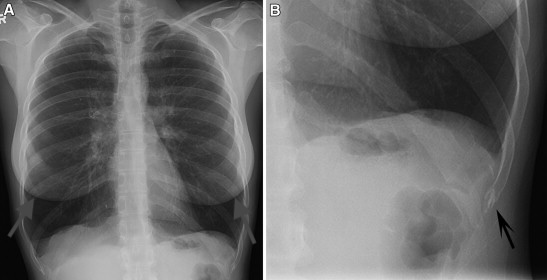

    (In the left image, the gray arrow points to the breast shadow, while in the right image, the black arrow indicates the central pattern of costal cartilage calcification.)

* **View Position**

    PA views are of higher **quality** and allow for a more accurate assessment of **heart size** compared to AP views.

| **Aspect**           | **PA View**                        | **AP View**                         |
|----------------------|------------------------------------|-------------------------------------|
| **Heart size**        | Normal heart size                  | Heart appears larger                |
| **Clavicles**         | Project over lung field            | Above lung field                    |
| **Scapulae**          | Retracted laterally                | Projected over lung field           |
| **Lung markings**     | Normal                             | Crowded                             |
| **Ribs**              | Posterior ribs are distinct        | Anterior ribs are distinct          |
| **Disc spaces**       | Not clearly seen                   | Clearly seen                        |

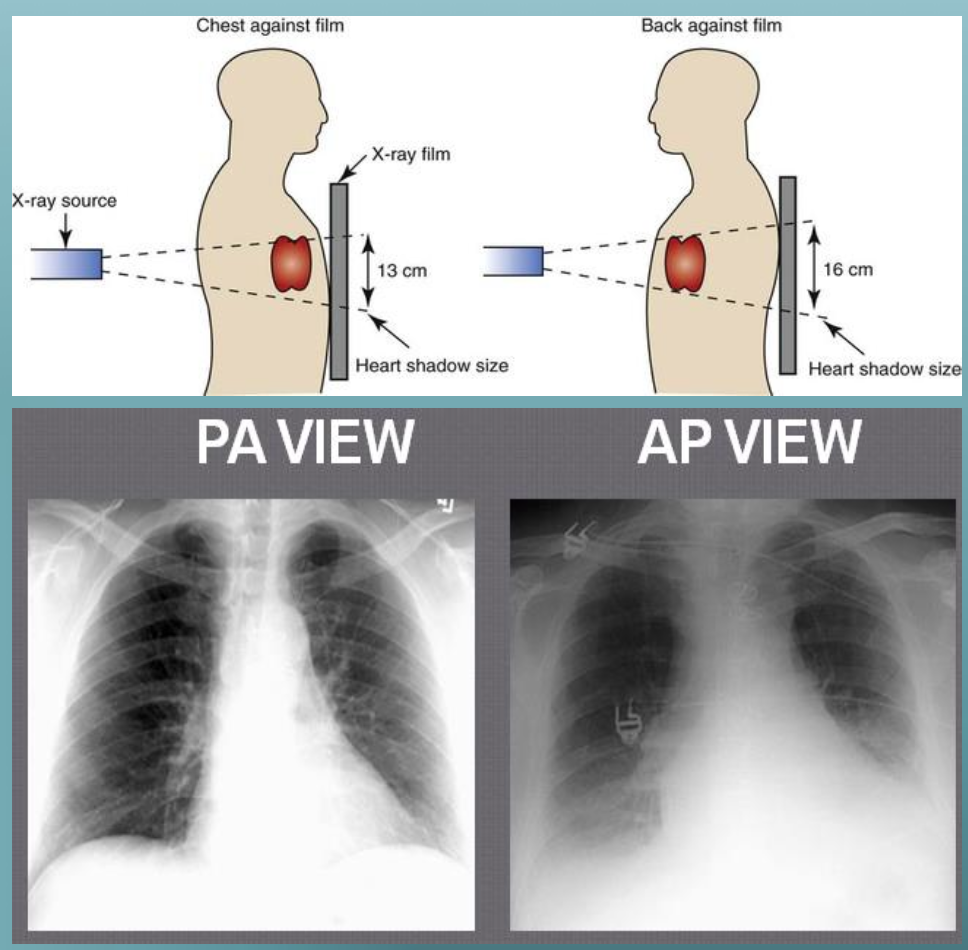

Ref:
* [Aging-Related Findings of the Respiratory System in Chest Imaging: Pearls and Pitfalls](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9713755/)
* [Geriatric Chest Imaging: When and How to Image the Elderly Lung, Age-Related Changes, and Common Pathologies](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3713368/)
* [Review of Thoracic Imaging Findings Unique to Women](https://www.sciencedirect.com/science/article/pii/S084653711400120X)
* [Radiat Prot Dosimetry. 2018 Feb 1;178(3):298-303.](https://www.researchgate.net/publication/342666950_Use_of_AP_Vs_PA_view_chest_X_rays_in_Medical_facility_of_Hamad_General_Hospital_Doha_Qatar)

In [ ]:
nonimage_data = merged_table[['patientId', 'age', 'sex', 'view_position', 'Target']]
nonimage_data['file_name'] = nonimage_data['patientId'].apply(lambda id: f"{id}.dcm")
# Ensure data type is consistent
nonimage_data.loc[:, 'patientId'] = nonimage_data['patientId'].astype(str)
nonimage_data.loc[:, 'age'] = nonimage_data['age'].astype(int)
nonimage_data.loc[:, 'sex'] = nonimage_data['sex'].astype(int)
nonimage_data.loc[:, 'view_position'] = nonimage_data['view_position'].astype(int)
nonimage_data.loc[:, 'Target'] = nonimage_data['Target'].astype(int)

<ipython-input-43-49b623a5b942>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonimage_data['file_name'] = nonimage_data['patientId'].apply(lambda id: f"{id}.dcm")


In [ ]:
nonimage_data.head(2)

,patientId,age,sex,view_position,Target,file_name
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,0,1,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
1,000924cf-0f8d-42bd-9158-1af53881a557,19,0,0,0,000924cf-0f8d-42bd-9158-1af53881a557.dcm


### Image

The image pixels are too large to fit into memory, so we need to create a generator that loads data on the fly.

### Splitting the Dataset

* Training set: 70%
* Validation set: 15%
* Test set: 15%

In [ ]:
# Split the dataset into 70% train and 30% (temp) for validation + test
train, temp = train_test_split(nonimage_data, test_size=0.3, random_state=42, shuffle=True)

# Split the temp set into 50% validation and 50% test (0.15 each of original dataset)
val, test = train_test_split(temp, test_size=0.5, random_state=42, shuffle=True)

In [ ]:
print(f"Number of samples in the train set: {len(train)}")
print(f"Number of samples in the validation set: {len(val)}")
print(f"Number of samples in the test set: {len(test)}")

Number of samples in the train set: 17782
Number of samples in the validation set: 3810
Number of samples in the test set: 3811


### Data Pipeline and Data Augmentation

**Merge image and non-image data**

In our training process, we are using a dataset that includes both image data and non-image data (age, sex, view position). Although Keras supports models with multiple inputs, `tf.keras` multi input models don't work when used together with `tf.data.Dataset` due to input broken validation checks.

As a result, we must merge the image data and non-image data into one tensor (flattened image + non-image data) to simplify the data pipeline and ensure compatibility with the training process.



In [ ]:
# Merge image and non-image data for original image
def process_data(patient_data):

    file_name = patient_data['file_name']

    file_path = tf.strings.join(["stage_2_train_images", file_name], separator='/')

    dicom_file = tf.io.read_file(file_path)
    image = tfio.image.decode_dicom_image(dicom_file, dtype=tf.uint16)
    image = tf.image.resize(image, [256, 256])
    image = image / 255
    flattened_image = tf.reshape(image, [-1])

    # Combine all features into a single tensor vector
    # nonimage = [patient_data['sex'], patient_data['view_position']]

    nonimage = tf.convert_to_tensor([patient_data['sex'], patient_data['age'], patient_data['view_position']], dtype=tf.float32)
    combined_tensor = tf.concat([flattened_image, nonimage], axis=0)
    # combined_tensor = tf.reshape(combined_tensor, (-1, 65538))



    # nonimage = tf.stack([patient_data['sex'], patient_data['view_position']], axis=0)
    # combined_feature = tf.stack([image, nonimage], axis=0)

    # Obtain the label from csv file
    # label = patient_data['Target']

    label = tf.convert_to_tensor(patient_data['Target'], dtype=tf.int64)
    label = tf.expand_dims(label, axis=-1)
    label = tf.ensure_shape(label, [1])

    return combined_tensor, label

**Data Augmentation**

In our dataset, there exists a significant **class imbalance** between the "pneumonia" and "no pneumonia" groups. This imbalance presents a challenge for the model to accurately generalize across both classes, as the model may become biased towards the majority class, leading to suboptimal performance in identifying the minority class. To address this, we will apply data augmentation to the "pneumonia" group to increase the number of samples.

In [ ]:
train_pneumonia = train[train['Target'] == 1]
train_no_pneumonia = train[train['Target'] == 0]
print(f"Number of Pneumonia in the train set: {len(train_pneumonia)}")
print(f"Number of Pneumonia in the train set: {len(train_no_pneumonia)}")
print(f"The ratio between pneumonia and nonpneumonia class: {len(train_no_pneumonia)/len(train_pneumonia)}")

Number of Pneumonia in the train set: 3925
Number of Pneumonia in the train set: 13857
The ratio between pneumonia and nonpneumonia class: 3.5304458598726116


In [ ]:
def augment_image(image):
    # Apply random augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

In [ ]:
# Merge image and non-image data for augmented image
def process_augmented_data(patient_data):

    file_name = patient_data['file_name']

    file_path = tf.strings.join(["stage_2_train_images", file_name], separator='/')

    dicom_file = tf.io.read_file(file_path)
    image = tfio.image.decode_dicom_image(dicom_file, dtype=tf.uint16)
    image = tf.image.resize(image, [256, 256])
    image = image / 255
    image = augment_image(image)
    flattened_image = tf.reshape(image, [-1])

    # Combine all features into a single tensor vector
    nonimage = tf.convert_to_tensor([patient_data['sex'], patient_data['age'], patient_data['view_position']], dtype=tf.float32)
    combined_tensor = tf.concat([flattened_image, nonimage], axis=0)

    # Obtain the label
    label = tf.convert_to_tensor(patient_data['Target'], dtype=tf.int64)
    label = tf.expand_dims(label, axis=-1)
    label = tf.ensure_shape(label, [1])

    return combined_tensor, label

Since the sample size of the pneumonia group is smaller, we applied data augmentation to the pneumonia images to equalize the number of samples between the pneumonia and no-pneumonia groups, addressing the class imbalance.

In [ ]:
# Build up train dataset pipeline
train_no_pneumonia_dataset = tf.data.Dataset.from_tensor_slices(dict(train_no_pneumonia))
train_pneumonia_dataset = tf.data.Dataset.from_tensor_slices(dict(train_pneumonia))

# The ratio between "no pneumonia" and "pneumonia" group is 3.5
# Add 2.5X augmented "pneumonia" data to achieve class balance
train_pneumonia_augmented_dataset = train_pneumonia_dataset.repeat(3)
train_pneumonia_augmented_dataset = train_pneumonia_augmented_dataset.shuffle(buffer_size=100).take(len(train_no_pneumonia) - len(train_pneumonia))
train_pneumonia_augmented_dataset = train_pneumonia_augmented_dataset.map(process_augmented_data)

train_no_pneumonia_dataset = train_no_pneumonia_dataset.map(process_data)
train_pneumonia_dataset = train_pneumonia_dataset.map(process_data)
# Concatenate train dataset from "pneumonia", "augmented pneumonia" and "no penumonia" dataset
train_dataset = train_pneumonia_dataset.concatenate(train_no_pneumonia_dataset).concatenate(train_pneumonia_augmented_dataset)
train_dataset = train_dataset.shuffle(buffer_size=5000, seed=42)

# Build up validation and test dataset pipeline
val_dataset = tf.data.Dataset.from_tensor_slices(dict(val))
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test))
val_dataset = val_dataset.map(process_data)
test_dataset = test_dataset.map(process_data)

Check the shape of our tensorflow dataset.

In [ ]:
for data, label in train_dataset.take(1):
    print(data.shape)
    print(label.shape)

(65539,)
(1,)


Examine the DICOM image



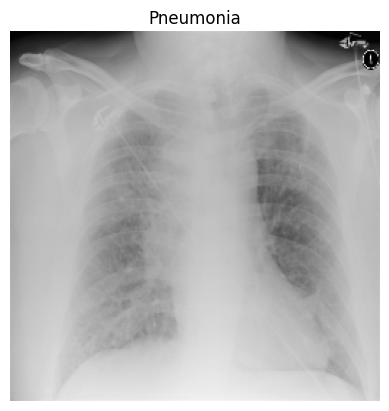

In [ ]:
# Display the image using matplotlib
for data, label in train_dataset.take(1):
    # flattened_image = tf.slice(data, [0, 0], [-1, 256*256])
    # image = tf.reshape(flattened_image, (256, 256))
    flattened_image = data.numpy()[0: 256*256]
    image = flattened_image.reshape(256, 256)

    plt.imshow(image, cmap='gray')
    plt.title('Pneumonia' if label == 1 else "No Pneumonia")
    plt.axis('off')  # Hide axes
    plt.show()

Prefetch and batch both datasets

In [ ]:
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Part 5: Modeling

### 5.1: Model Architecture

Models with multiple inputs

* Concatenate the CNN features with the
 additional features:
 Combine the output of the CNN with the additional features (structured data) to form a single input vector.
* Pass the combined features through fully connected layers:
After concatenating, pass the combined features through dense layers and then output the final classification.

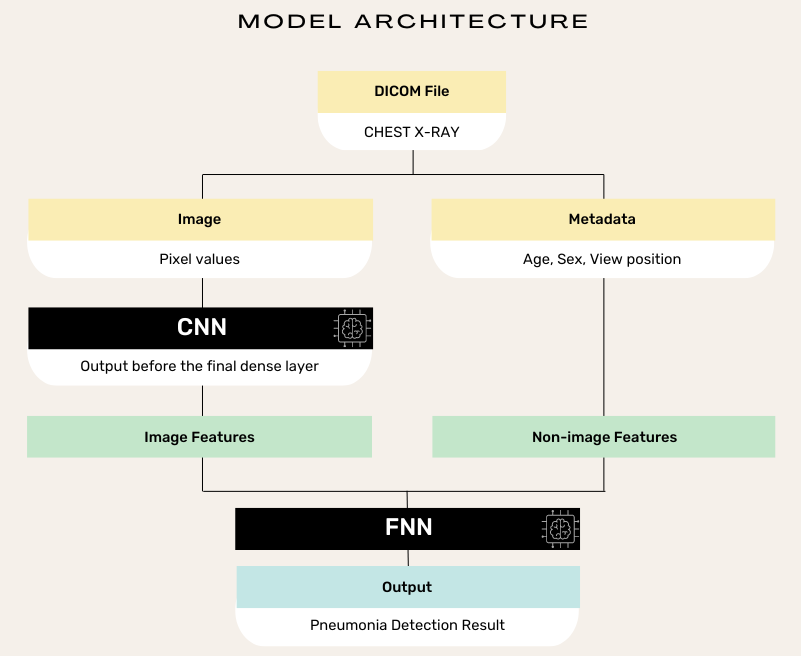

### Hyperparameter Tuning

* Learning rate
* Number of neurons for layers
* Dropout rate

In [ ]:
def model_builder(hp):
    set_random_seed()

    image_size = 256*256
    nonimage_feature_number = 3
    input_size = image_size + nonimage_feature_number

    # Define the inputs (image and nonimage inputs)
    input = keras.Input(
        shape=(input_size,), name="input"
    )  # Binary vectors of size `num_tags`

    # Use Lambda layers to slice and reshape the input for image and non-image parts
    # Use Lambda layers to slice and reshape the input for image and non-image parts
    flattened_image = keras.layers.Lambda(
        lambda x: tf.slice(x, [0, 0], [-1, image_size]),
        output_shape=(image_size,)
    )(input)

    image_input = keras.layers.Reshape((256, 256, 1))(flattened_image)

    nonimage_input = keras.layers.Lambda(
        lambda x: tf.slice(x, [0, image_size], [-1, 3]),
        output_shape=(nonimage_feature_number,)
    )(input)


    # Add convolutional layers
    filter_1 = hp.Int('filter_1', min_value=32, max_value=128, step=32)
    x = keras.layers.Conv2D(filter_1, (3, 3), activation='relu')(image_input)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    x= keras.layers.Dropout(hp_dropout)(x)

    filter_2 = hp.Int('filter_2', min_value=32, max_value=128, step=32)
    x = keras.layers.Conv2D(filter_2, (3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x= keras.layers.Dropout(hp_dropout)(x)

    filter_3 = hp.Int('filter_3', min_value=32, max_value=128, step=32)
    x = keras.layers.Conv2D(filter_3, (3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(hp_dropout)(x)

    image_features = keras.layers.Flatten()(x)

    x = keras.layers.concatenate([image_features, nonimage_input])
    # Stick a logistic regression for priority prediction on top of the features
    units_1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    x = keras.layers.Dense(units_1, activation='relu')(x)
    units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    x = keras.layers.Dense(units_2, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    # Instantiate an end-to-end model predicting both priority and department
    model = keras.Model(
        inputs=input,
        outputs=outputs
    )

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss='binary_crossentropy',
                    metrics=[metrics.BinaryAccuracy(), metrics.Precision(),
                             metrics.Recall(), metrics.AUC()])

    return model

**Instantiate the tuner and perform hypertuning**

The Keras Tuner has four tuners available - RandomSearch, Hyperband, BayesianOptimization, and Sklearn. Given the large seach space for the model architecture, we will apply Hyperband.

> The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round.



In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_binary_accuracy',
                     max_epochs=10,
                     factor=3,
                     overwrite=False,
                     directory='my_dir',
                     project_name='optimal_architecture')

Reloading Tuner from my_dir/optimal_architecture/tuner0.json


Create a callback to stop training early after reaching a certain value for the validation loss.




In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Run the hyperparameter search.

In [ ]:
tuner.search(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
First convolutional layer filter number: {best_hps.get('filter_1')}.
Second convolutional layer filter number: {best_hps.get('filter_2')}.
Third convolutional layer filter number: {best_hps.get('filter_3')}.
Optimal dropout rate: {best_hps.get('dropout')}.
The optimal number of units in the first densely-connected layer is {best_hps.get('units_1')}.
The optimal number of units in the second densely-connected layer is {best_hps.get('units_2')}.
 and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 28 Complete [00h 01m 25s]

Best val_binary_accuracy So Far: 0.7816272974014282
Total elapsed time: 19h 48m 47s

The hyperparameter search is complete.
First convolutional layer filter number: 96.
Second convolutional layer filter number: 128.
Third convolutional layer filter number: 64.
Optimal dropout rate: 0.1.
The optimal number of units in the first densely-connected layer is 416.
The optimal number of units in the second densely-connected layer is 512.
 and the optimal learning rate for the optimizer
is 0.001.



Store the optimal hyperparameters

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

filter_1 = best_hps.get('filter_1')
filter_2 = best_hps.get('filter_2')
filter_3 = best_hps.get('filter_3')
hp_dropout = best_hps.get('dropout')
units_1 = best_hps.get('units_1')
units_2 = best_hps.get('units_2')
learning_rate = best_hps.get('learning_rate')

### Model Training

Load the tuner from the saved directory.

Build the model based on the optimal
hyperparameters.

In [ ]:
# Get the best hyperparameter
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [ ]:
def final_model_builder():
    set_random_seed()

    image_size = 256*256
    nonimage_feature_number = 3
    input_size = image_size + nonimage_feature_number

    # Define the inputs (image and nonimage inputs)
    input = keras.Input(
        shape=(input_size,), name="input"
    )  # Binary vectors of size `num_tags`

    # Use Lambda layers to slice and reshape the input for image and non-image parts
    # Use Lambda layers to slice and reshape the input for image and non-image parts
    flattened_image = keras.layers.Lambda(
        lambda x: tf.slice(x, [0, 0], [-1, image_size]),
        output_shape=(image_size,)
    )(input)

    image_input = keras.layers.Reshape((256, 256, 1))(flattened_image)

    nonimage_input = keras.layers.Lambda(
        lambda x: tf.slice(x, [0, image_size], [-1, 3]),
        output_shape=(nonimage_feature_number,)
    )(input)


    # Add convolutional layers
    x = keras.layers.Conv2D(filter_1, (3, 3), activation='relu')(image_input)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x= keras.layers.Dropout(hp_dropout)(x)

    x = keras.layers.Conv2D(filter_2, (3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x= keras.layers.Dropout(hp_dropout)(x)

    x = keras.layers.Conv2D(filter_3, (3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(hp_dropout)(x)

    image_features = keras.layers.Flatten()(x)

    x = keras.layers.concatenate([image_features, nonimage_input])
    # Stick a logistic regression for priority prediction on top of the features
    x = keras.layers.Dense(units_1, activation='relu')(x)
    x = keras.layers.Dense(units_2, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    # Instantiate an end-to-end model predicting both priority and department
    model = keras.Model(
        inputs=input,
        outputs=outputs
    )

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001

    return model

In [ ]:
model = final_model_builder()
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 65539)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_14 (Lambda)        │ (None, 65536)          │              0 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 256, 256, 1)    │              0 │ lambda_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 254, 254, 96)   │            960 │ reshape_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 127, 127, 96)   │              0 │ conv2d_21[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 127, 127, 96)   │              0 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 125, 125, 128)  │        110,720 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 62, 62, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 62, 62, 128)    │              0 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 60, 60, 64)     │         73,792 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 30, 30, 64)     │              0 │ conv2d_23[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 30, 30, 64)     │              0 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 57600)          │              0 │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_15 (Lambda)        │ (None, 3)              │              0 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 57603)          │              0 │ flatten_7[0][0],       │
│ (Concatenate)             │                        │                │ lambda_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 416)            │     23,963,264 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 512)            │        213,504 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)     

 Total params: 24,362,753 (92.94 MB)

 Trainable params: 24,362,753 (92.94 MB)

 Non-trainable params: 0 (0.00 B)

Define EarlyStopping with val_auc as the monitor

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=10,               # Wait for 3 epochs with no improvement
    mode='min',                # AUC should be maximized
    restore_best_weights=True  # Restore the best weights after stopping
)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[metrics.BinaryAccuracy(name='accuracy'),
                       metrics.AUC(name='auc'),
                       metrics.Precision(name='precision'),
                       metrics.Recall(name='recall')
                       ])

In [ ]:
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[stop_early])

Epoch 1/100
867/867 ━━━━━━━━━━━━━━━━━━━━ 1923s 2s/step - accuracy: 0.8004 - auc: 0.8598 - loss: 0.4302 - precision: 0.7704 - recall: 0.7034 - val_accuracy: 0.6696 - val_auc: 0.7031 - val_loss: 0.7100 - val_precision: 0.3519 - val_recall: 0.6074
Epoch 2/100
867/867 ━━━━━━━━━━━━━━━━━━━━ 770s 825ms/step - accuracy: 0.8021 - auc: 0.8654 - loss: 0.4202 - precision: 0.7685 - recall: 0.7212 - val_accuracy: 0.6323 - val_auc: 0.7399 - val_loss: 0.8613 - val_precision: 0.3502 - val_recall: 0.7971
Epoch 3/100
867/867 ━━━━━━━━━━━━━━━━━━━━ 768s 824ms/step - accuracy: 0.8142 - auc: 0.8714 - loss: 0.4112 - precision: 0.7831 - recall: 0.7354 - val_accuracy: 0.7087 - val_auc: 0.7426 - val_loss: 0.6020 - val_precision: 0.3956 - val_recall: 0.6303
Epoch 4/100
867/867 ━━━━━━━━━━━━━━━━━━━━ 769s 825ms/step - accuracy: 0.8162 - auc: 0.8731 - loss: 0.4072 - precision: 0.7874 - recall: 0.7413 - val_accuracy: 0.7501 - val_auc: 0.7432 - val_loss: 0.5254 - val_precision: 0.4255 - val_recall: 0.4082
Epoch 5/100
86

Plot the training curve

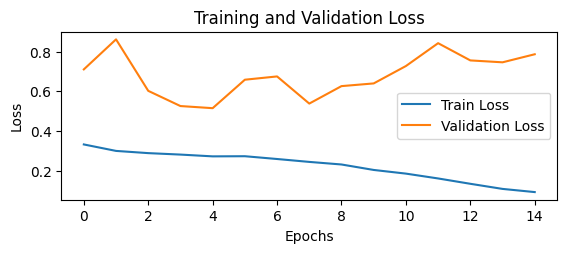

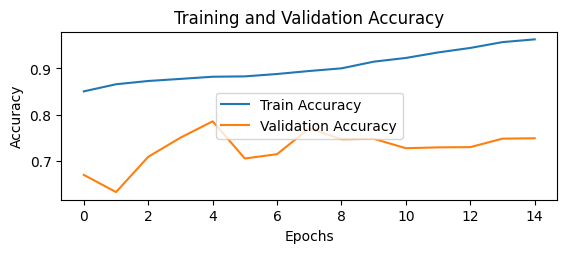

In [ ]:
# Access the training history
history_dict = history.history

# Plotting function
def plot_metric(metric):
    plt.plot(history_dict[metric], label=f'Train {metric.capitalize()}')
    plt.plot(history_dict[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.show()

# Plot Loss, Accuracy, AUC, Precision, and Recall
metrics_to_plot = ['loss', 'accuracy']
i = 1
for metric in metrics_to_plot:
    plt.subplot(2, 1, i)
    plot_metric(metric)
    i += 1
plt.show()

Save the basic model

In [ ]:
# Save the model
model.save("augmented_model.keras")

### Evaluate Model on Test Set

In [ ]:
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
x_test = test_dataset.map(lambda x, y: x)
y_test = test_dataset.map(lambda x, y: y)

In [ ]:
results = model.evaluate(test_dataset)
print(f"Accuracy: {results[2]:.2f}")
print(f"Precision: {results[3]:.2f}")
print(f"Sensitivity: {results[4]:.2f}")

120/120 ━━━━━━━━━━━━━━━━━━━━ 239s 361ms/step - auc_1: 0.8069 - binary_accuracy: 0.7499 - loss: 0.4140 - precision: 0.5701 - recall: 0.7316
Accuracy: 0.7128608822822571
Precision: 0.39317405223846436
Sensitivity: 0.7375159859657288
